In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.time import Time
from astropy import units


In [2]:

def load_data(data_path, rechunk=None):
    sens_data = np.loadtxt(data_path)
    freq_arr = sens_data[:-1, 0] * 1e9
    tau_arr =  sens_data[:-1, 1]
    tb_arr = sens_data[:-1, 3]
    delta_nu = 1e6

    if rechunk is not None:
        residual = len(freq_arr) % rechunk
        data_slice = slice(-residual if (residual != 0) else None)
        freq_arr = np.mean(freq_arr[data_slice].reshape(-1, rechunk), axis=-1)
        tau_arr = np.median(tau_arr[data_slice].reshape(-1, rechunk), axis=-1)
        tb_arr = np.median(tb_arr[data_slice].reshape(-1, rechunk), axis=-1)
        delta_nu *= rechunk

    return freq_arr, tau_arr, tb_arr, delta_nu

def calc_sens(
    freq_arr,
    sky_tb_arr,
    sky_tau_arr,
    el_angle,
    inst_setup,
    eta_obs=0.67,
):
    rx_grade = inst_setup["rx_grade"]
    n_pol = inst_setup["n_pol"]
    delta_nu = inst_setup["delta_nu"]
    t_int = inst_setup["t_int"]
    n_ants = inst_setup["n_ants"]
    ap_eff = inst_setup["ap_eff"]
    is_dsb = inst_setup["is_dsb"]

    trx_arr = (4.79924307e-11) * rx_grade * freq_arr

    trans_arr = np.exp(
        -np.minimum((sky_tau_arr / np.cos((90. - el_angle) * np.pi / 180.0)), 20.)
    )

    tb_arr = sky_tb_arr * (
        np.divide(
            1 - np.exp(-sky_tau_arr / np.cos((90 - el_angle) * np.pi / 180.)),
            1 - np.exp(-sky_tau_arr),
        )
    )
    tsys_arr = (((1 + is_dsb) * tb_arr) + (2 * trx_arr)) / trans_arr

    sens_arr = (eta_obs**-0.5) * tsys_arr * (
        (97.6 / ap_eff) / np.sqrt(n_pol * n_ants * (n_ants - 1) * delta_nu * t_int)
    )
    
    return tsys_arr, sens_arr


def print_sens(freq_arr, tsys_arr, sens_arr, freq_range_dict, title=None, delta_nu=1e6):
    if title is not None:
        print(title)
        print("")
    print("      Band|       Tsys|  Cont sens|  Line sens (1 km/s chan)")
    print("          |        [K]|      [mJy]|      [mJy]|  [Jy*km/s]")
    print("----------|-----------|-----------|-----------|-----------")
    for name, freq_lims in freq_range_dict.items():
        delta_v = (delta_nu / (1e9 * np.mean(freq_lims))) * 3e5
        freq_mask = (freq_lims[0] * 1e9 < freq_arr) & (freq_lims[1] * 1e9 > freq_arr)
        tsys_val = np.nanmedian(tsys_arr[freq_mask])
        cont_sens = 1000 * np.nansum(sens_arr[freq_mask] ** -2.0) ** (-0.5)
        line_sens = 1000 * np.nanmedian(sens_arr[freq_mask]) * np.sqrt(delta_v)
        vel_sens = np.nanmedian(sens_arr[freq_mask]) * np.sqrt(delta_v)

        print("%9s | % 9.1f | % 9.3f | % 9.1f | % 9.4f " % (name, tsys_val, cont_sens, line_sens, vel_sens))
    print(" ")
    print(" ")


In [3]:

freq_arr, tau_arr, tb_arr, delta_nu = load_data("sites/SMA/avgmk.out", rechunk=10)

reg_sma = {
    "rx_grade": 6,
    "n_pol": 1,
    "delta_nu": delta_nu,
    "t_int": 1800.,
    "n_ants": 8.,
    "ap_eff": 0.7*0.8,
    "is_dsb": True,
}

super_wsma = {
    "rx_grade": 3,
    "n_pol": 1,
    "delta_nu": delta_nu,
    "t_int": 3600.,
    "n_ants": 8.,
    "ap_eff": 0.7*0.9,
    "is_dsb": False,
}

freq_range_dict = {
    "90 GHz" : [84, 116],
    "150 GHz": [120, 180],
    "230 GHz": [200, 264],
    "345 GHz": [330, 370],
    "420 GHz": [380, 450],
    "490 GHz": [450, 510],
    "690 GHz": [630, 694],    
}

freq_range_dict = {
    "230 GHz": [216, 240],
    "345 GHz": [344, 346],
}

tsys_arr, sens_arr = calc_sens(freq_arr, tb_arr, tau_arr, 30.0, inst_setup=reg_sma, eta_obs=1)
print_sens(freq_arr, tsys_arr, sens_arr, freq_range_dict, "1-Hour array sensitivities (avg weather - 2 mm PWV)")

freq_range_dict = {
    "90 GHz" : [84, 116],
    "230 GHz": [210, 250],
    "345 GHz": [330, 370],
}

tsys_arr, sens_arr = calc_sens(freq_arr, tb_arr, tau_arr, 68.0, inst_setup=super_wsma)
print_sens(freq_arr, tsys_arr, sens_arr, freq_range_dict, "1-Hour array sensitivities (avg weather - 2 mm PWV)")


1-Hour array sensitivities (avg weather - 2 mm PWV)

      Band|       Tsys|  Cont sens|  Line sens (1 km/s chan)
          |        [K]|      [mJy]|      [mJy]|  [Jy*km/s]
----------|-----------|-----------|-----------|-----------
  230 GHz |     255.4 |     0.913 |      50.9 |    0.0509 
  345 GHz |     773.8 |     9.461 |     125.3 |    0.1253 
 
 
1-Hour array sensitivities (avg weather - 2 mm PWV)

      Band|       Tsys|  Cont sens|  Line sens (1 km/s chan)
          |        [K]|      [mJy]|      [mJy]|  [Jy*km/s]
----------|-----------|-----------|-----------|-----------
   90 GHz |      39.9 |     0.099 |       9.2 |    0.0092 
  230 GHz |      98.9 |     0.210 |      15.1 |    0.0151 
  345 GHz |     268.2 |     0.593 |      33.1 |    0.0331 
 
 


In [4]:
bad_freq_arr, bad_tau_arr, bad_tb_arr, bad_delta_nu = load_data("sites/SMA/badmk.out", rechunk=10)
avg_freq_arr, avg_tau_arr, avg_tb_arr, avg_delta_nu = load_data("sites/SMA/avgmk.out", rechunk=10)
good_freq_arr, good_tau_arr, good_tb_arr, good_delta_nu = load_data("sites/SMA/goodmk.out", rechunk=10)

In [5]:
super_wsma = {
    "rx_grade": 3,
    "n_pol": 2,
    "delta_nu": avg_delta_nu,
    "t_int": 2*3600.,
    "n_ants": 8.,
    "ap_eff": 0.675,
    "is_dsb": False,
}

reg_sma = {
    "rx_grade": 7,
    "n_pol": 1,
    "delta_nu": avg_delta_nu,
    "t_int": 2*3600.,
    "n_ants": 8.,
    "ap_eff": 0.7,
    "is_dsb": True,
}

freq_range_dict = {
    "90 GHz" : [84, 116],
    "150 GHz": [120, 180],
    "230 GHz": [200, 264],
    "345 GHz": [330, 370],
    "420 GHz": [380, 450],
    "490 GHz": [450, 510],
    "690 GHz": [630, 694],    
}

freq_range_dict = {
    "90 GHz" : [84, 116],
    "230 GHz": [200, 240],
    "345 GHz": [330, 370],
}

freq_range_dict = {
    "230 GHz": [216, 240],
    "345 GHz": [338, 362],
}


utc_hrs = np.linspace(0, 24, 1440, endpoint=False)
obstime = Time(57261.9990469, format="mjd") + (utc_hrs / 24) * units.day
site = EarthLocation.of_site("Subaru")
sou_targ = SkyCoord(0, 0, unit="deg", frame="icrs", location=site, obstime=obstime)

sou_altaz = sou_targ.transform_to("altaz")
el_arr = [60.] # sou_altaz[sou_altaz.alt.deg > 60.0].alt.deg

for item in freq_range_dict:
    data_mask = (avg_freq_arr/1e9 > freq_range_dict[item][0]) & (avg_freq_arr/1e9 < freq_range_dict[item][1])
    cont_arr = np.zeros_like(el_arr)
    line_arr = np.zeros_like(el_arr)
    for idx, el_deg in enumerate(el_arr):
        tsys_arr, sens_arr = calc_sens(avg_freq_arr, avg_tb_arr, avg_tau_arr, el_deg, inst_setup=super_wsma)
        line_arr[idx] = np.median(sens_arr[data_mask])
        cont_arr[idx] = np.sum(sens_arr[data_mask]**-2)**-0.5
    print("% 7s: %.4f mJy/beam" % (item, ((0.67**(-0.5))*1e3*np.sum(cont_arr**-2)**-0.5)))

print("Hours: %.1f" % (0.67 * len(cont_arr) / 60.))

for item in freq_range_dict:
    data_mask = (avg_freq_arr/1e9 > freq_range_dict[item][0]) & (avg_freq_arr/1e9 < freq_range_dict[item][1])
    cont_arr = np.zeros_like(el_arr)
    line_arr = np.zeros_like(el_arr)
    for idx, el_deg in enumerate(el_arr):
        tsys_arr, sens_arr = calc_sens(avg_freq_arr, avg_tb_arr, avg_tau_arr, el_deg, inst_setup=reg_sma)
        line_arr[idx] = np.median(sens_arr[data_mask])
        cont_arr[idx] = np.sum(sens_arr[data_mask]**-2)**-0.5
    print("% 7s: %.4f mJy/beam" % (item, ((0.67**(-0.5))*1e3*np.sum(cont_arr**-2)**-0.5)))

print("Hours: %.1f" % (0.67 * len(cont_arr) / 60.))


230 GHz: 0.1564 mJy/beam
345 GHz: 0.4196 mJy/beam
Hours: 0.0
230 GHz: 0.4780 mJy/beam
345 GHz: 1.2502 mJy/beam
Hours: 0.0


In [6]:
delta_time = 60.

reg_sma_lo = {
    "rx_grade": 6,
    "n_pol": 1,
    "delta_nu": avg_delta_nu,
    "t_int": delta_time,
    "n_ants": 8.,
    "ap_eff": 0.7 * 0.8,
    "is_dsb": True,
}

reg_sma_hi = {
    "rx_grade": 7,
    "n_pol": 1,
    "delta_nu": avg_delta_nu,
    "t_int": delta_time,
    "n_ants": 8.,
    "ap_eff": 0.63 * 0.8,
    "is_dsb": True,
}

reg_wsma = {
    "rx_grade": 3,
    "n_pol": 1,
    "delta_nu": avg_delta_nu,
    "t_int": delta_time,
    "n_ants": 8.,
    "ap_eff": 0.7*0.9,
    "is_dsb": True,
}

super_wsma = {
    "rx_grade": 3,
    "n_pol": 2,
    "delta_nu": avg_delta_nu,
    "t_int": delta_time,
    "n_ants": 8.,
    "ap_eff": 0.7*0.9,  # Account for insertion loss
    "is_dsb": False,
}

sma_lo_freq_range_dict = {
    "230 GHz": [216, 240],
    "240 GHz": [216, 240],
}

sma_hi_freq_range_dict = {
    "345 GHz": [338, 362],
    "400 GHz": [400, 420],
}

stage_i_freq_range_dict = {
    "230 GHz": [216, 240],
    "345 GHz": [338, 362],
}

stage_ii_freq_range_dict = {
    "90 GHz" : [84, 116],
    "230 GHz": [200, 240],
    "345 GHz": [330, 370],
}

# Super wSMA
stage_iii_freq_range_dict = {
    "90 GHz" : [84, 116],
    "150 GHz": [120, 170],
    "230 GHz": [190, 250],
    "270 GHz": [255, 315],
    "345 GHz": [325, 375],
    "420 GHz": [385, 445],
}

stage_iii_upper_freq_range_dict = {
    "490 GHz": [455, 515],
    "690 GHz": [660, 720],
}


utc_hrs = np.linspace(0, 24, int(86400 / delta_time), endpoint=False)
obstime = Time(57261.9990469, format="mjd") + (utc_hrs / 24) * units.day
site = EarthLocation.of_site("Subaru")
sou_targ = SkyCoord(0, -10, unit="deg", frame="icrs", location=site, obstime=obstime)
sou_altaz = sou_targ.transform_to("altaz")
el_arr = sou_altaz[sou_altaz.alt.deg > 20.0].alt.deg
el_arr = [max(el_arr)]

freq_arr = avg_freq_arr
tb_arr = avg_tb_arr
tau_arr = avg_tau_arr
weather_text = "avg weather - 2 mm PWV"

sens_arr = np.zeros_like(good_freq_arr)
tsys_arr = np.zeros_like(good_freq_arr)
for idx, el_deg in enumerate(el_arr):
    temp_tsys, temp_sens = calc_sens(freq_arr, tb_arr, tau_arr, el_deg, inst_setup=reg_sma_lo)
    sens_arr += temp_sens**(-2.0)
    tsys_arr += temp_tsys

sens_arr = sens_arr**(-0.5)
tsys_arr /= len(el_arr)
print_sens(freq_arr, tsys_arr, sens_arr, sma_lo_freq_range_dict, "SMA 230/240 sensitivities (%s)" % weather_text, delta_nu=avg_delta_nu)

sens_arr = np.zeros_like(good_freq_arr)
tsys_arr = np.zeros_like(good_freq_arr)
for idx, el_deg in enumerate(el_arr):
    temp_tsys, temp_sens = calc_sens(freq_arr, tb_arr, tau_arr, el_deg, inst_setup=reg_sma_hi)
    sens_arr += temp_sens**(-2.0)
    tsys_arr += temp_tsys

sens_arr = sens_arr**(-0.5)
tsys_arr /= len(el_arr)
print_sens(freq_arr, tsys_arr, sens_arr, sma_hi_freq_range_dict, "SMA 345/400 sensitivities (%s)" % weather_text, delta_nu=avg_delta_nu)

sens_arr = np.zeros_like(good_freq_arr)
tsys_arr = np.zeros_like(good_freq_arr)
for idx, el_deg in enumerate(el_arr):
    temp_tsys, temp_sens = calc_sens(freq_arr, tb_arr, tau_arr, el_deg, inst_setup=reg_wsma)
    sens_arr += temp_sens**(-2.0)
    tsys_arr += temp_tsys

sens_arr = sens_arr**(-0.5)
tsys_arr /= len(el_arr)
print_sens(freq_arr, tsys_arr, sens_arr, stage_i_freq_range_dict, "wSMA Phase I sensitivities (%s)" % weather_text, delta_nu=avg_delta_nu)

sens_arr = np.zeros_like(good_freq_arr)
tsys_arr = np.zeros_like(good_freq_arr)
for idx, el_deg in enumerate(el_arr):
    temp_tsys, temp_sens = calc_sens(freq_arr, tb_arr, tau_arr, el_deg, inst_setup=super_wsma)
    sens_arr += temp_sens**(-2.0)
    tsys_arr += temp_tsys

sens_arr = sens_arr**(-0.5)
tsys_arr /= len(el_arr)
print_sens(freq_arr, tsys_arr, sens_arr, stage_ii_freq_range_dict, "wSMA Phase II sensitivities (%s)" % weather_text, delta_nu=avg_delta_nu)
print_sens(freq_arr, tsys_arr, sens_arr, stage_iii_freq_range_dict, "wSMA Phase III sensitivities (%s)" % weather_text, delta_nu=avg_delta_nu)

sens_arr = np.zeros_like(good_freq_arr)
tsys_arr = np.zeros_like(good_freq_arr)
for idx, el_deg in enumerate(el_arr):
    temp_tsys, temp_sens = calc_sens(good_freq_arr, good_tb_arr, good_tau_arr, el_deg, inst_setup=super_wsma)
    sens_arr += temp_sens**(-2.0)
    tsys_arr += temp_tsys

weather_text = "1 mm PWV"
sens_arr = sens_arr**(-0.5)
tsys_arr /= len(el_arr)
print_sens(freq_arr, tsys_arr, sens_arr, stage_iii_upper_freq_range_dict, "wSMA Phase III sensitivities (%s)" % weather_text, delta_nu=avg_delta_nu)


SMA 230/240 sensitivities (avg weather - 2 mm PWV)

      Band|       Tsys|  Cont sens|  Line sens (1 km/s chan)
          |        [K]|      [mJy]|      [mJy]|  [Jy*km/s]
----------|-----------|-----------|-----------|-----------
  230 GHz |     200.1 |     4.777 |     843.3 |    0.8433 
  240 GHz |     200.1 |     4.777 |     843.3 |    0.8433 
 
 
SMA 345/400 sensitivities (avg weather - 2 mm PWV)

      Band|       Tsys|  Cont sens|  Line sens (1 km/s chan)
          |        [K]|      [mJy]|      [mJy]|  [Jy*km/s]
----------|-----------|-----------|-----------|-----------
  345 GHz |     568.1 |    15.540 |    2146.6 |    2.1466 
  400 GHz |    1062.6 |    31.499 |    3709.9 |    3.7099 
 
 
wSMA Phase I sensitivities (avg weather - 2 mm PWV)

      Band|       Tsys|  Cont sens|  Line sens (1 km/s chan)
          |        [K]|      [mJy]|      [mJy]|  [Jy*km/s]
----------|-----------|-----------|-----------|-----------
  230 GHz |     127.5 |     2.711 |     477.6 |    0.4776 
  3

In [65]:

alma_bands = {
        'Band 1' :[ 35,  50],
        'Band 3' :[ 84, 116],
        'Band 4' :[125, 163],
        'Band 5' :[163, 211],
        'Band 6' :[211, 275],
        'Band 7' :[275, 373],
        'Band 8' :[385, 500],
        'Band 9' :[602, 720],
        'Band 10':[787, 950]
}

noema_bands = {
    'Band 1':[ 70.384, 119.316],
    'Band 2':[127.000, 182.872],
    'Band 3':[196.128, 276.000]
}

sma_bands = {
    'SMA230': [172, 254],
    'SMA240': [198, 278],
    'SMA345': [242, 367],
    'SMA400': [320, 424]
}

wsma_bands = {
    '1.3mm': [190, 290],
    '850um': [280, 380]
}

rset_bands = {
    '3mm': [ 84, 116],
    '1.3mm': [190, 290],
    '850um': [320, 380]
}

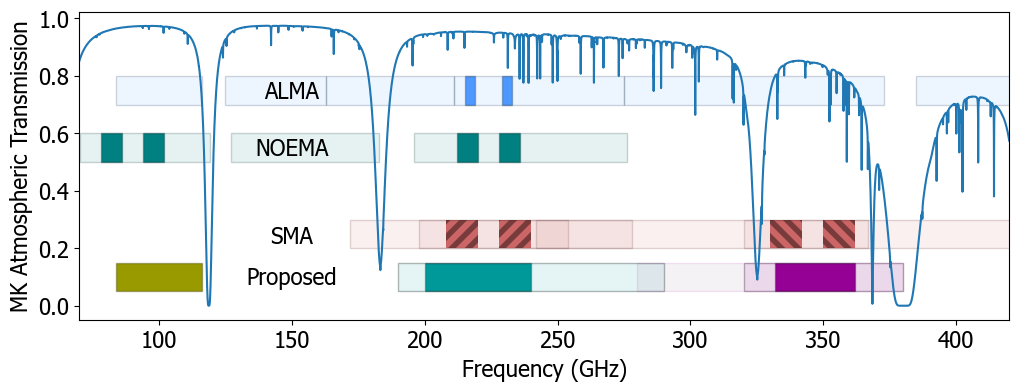

In [76]:



font = {'family' : 'tahoma',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)
plt.figure(figsize=(12,4))
plt.plot(good_freq_arr/1e9, np.exp(-good_tau_arr))
plt.xlim(70, 420)
alma_color = np.array([0.3, 0.6, 1.0, 1.0])
alma_edge_color = alma_color/3
alma_edge_color[3] = 1.0
alma_band_color = alma_color - np.array([0, 0, 0, 0.9])
alma_band_edge_color = alma_edge_color - np.array([0, 0, 0, 0.8])
noema_color = np.array([0, 0.5, 0.5, 1.0])
noema_edge_color = noema_color/3
noema_edge_color[3] = 1.0
noema_band_color = noema_color - np.array([0, 0, 0, 0.9])
noema_band_edge_color = noema_edge_color - np.array([0, 0, 0, 0.8])
sma_color = np.array([0.8, 0.4, 0.4, 1.0])
sma_edge_color = np.array([0.4, 0.2, 0.2, 1.0])
sma_band_color = sma_color - np.array([0, 0, 0, 0.9])
sma_band_edge_color = sma_edge_color - np.array([0, 0, 0, 0.8])

sma_3mm_color = np.array([0.6, 0.6, 0, 1])
sma_1mm_color = np.array([0, 0.6, 0.6, 1])
sma_1mm_edge_color = sma_1mm_color/3
sma_1mm_edge_color[3] = 0.6
sma_1mm_band_color = np.array([0, 0.6, 0.6, 0.1])
sma_850um_color = np.array([0.6, 0, 0.6, 1])
sma_850um_edge_color = sma_850um_color/3
sma_850um_edge_color[3] = 0.6
sma_850um_band_color = np.array([0.6, 0, 0.6, 0.1])

box = np.array([0, 0, 0.1, 0.1])

alma_freq = 224
plt.fill([alma_freq-5, alma_freq-9, alma_freq-9, alma_freq-5], 0.7+box,color=alma_color,edgecolor=alma_color/3)
plt.fill([alma_freq+5, alma_freq+9, alma_freq+9, alma_freq+5], 0.7+box,color=alma_color,edgecolor=alma_color/3)
plt.text(150, 0.745, 'ALMA', verticalalignment='center',horizontalalignment='center')

for band, freqs in alma_bands.items():
        plt.fill([freqs[0], freqs[1], freqs[1], freqs[0]], 0.7+box, color=alma_band_color, edgecolor=alma_band_edge_color)

noema_freq1=90
plt.fill([noema_freq1-4.1, noema_freq1-11.9, noema_freq1-11.9, noema_freq1-4.1], 0.5+box,color=noema_color,edgecolor=noema_color/3)
plt.fill([noema_freq1+4.1, noema_freq1+11.9, noema_freq1+11.9, noema_freq1+4.1], 0.5+box,color=noema_color,edgecolor=noema_color/3)
noema_freq2=224
plt.fill([noema_freq2-4.1, noema_freq2-11.9, noema_freq2-11.9, noema_freq2-4.1], 0.5+box,color=noema_color,edgecolor=noema_color/3)
plt.fill([noema_freq2+4.1, noema_freq2+11.9, noema_freq2+11.9, noema_freq2+4.1], 0.5+box,color=noema_color,edgecolor=noema_color/3)
plt.text(150, 0.545, 'NOEMA', verticalalignment='center',horizontalalignment='center')

for band, freqs in noema_bands.items():
        plt.fill([freqs[0], freqs[1], freqs[1], freqs[0]], 0.5+box, color=noema_band_color, edgecolor=noema_band_edge_color)

lo_freq = 224
plt.fill([lo_freq-4, lo_freq-16, lo_freq-16,lo_freq-4], 0.2+box,color=sma_color, hatch='//',edgecolor=sma_edge_color, linewidth=0)
plt.fill([lo_freq+4, lo_freq+16, lo_freq+16,lo_freq+4], 0.2+box,color=sma_color, hatch='//',edgecolor=sma_edge_color, linewidth=0)
plt.text(150, 0.24, 'SMA', verticalalignment='center',horizontalalignment='center')

hi_freq = 346
plt.fill([hi_freq-4, hi_freq-16, hi_freq-16, hi_freq-4], 0.2+box, color=sma_color, hatch='\\\\',edgecolor=sma_edge_color, linewidth=0)
plt.fill([hi_freq+4, hi_freq+16, hi_freq+16, hi_freq+4], 0.2+box, color=sma_color, hatch='\\\\',edgecolor=sma_edge_color, linewidth=0)

plt.rcParams['hatch.linewidth'] = 4

for band, freqs in sma_bands.items():
        plt.fill([freqs[0], freqs[1], freqs[1], freqs[0]], 0.2+box, color=sma_band_color, edgecolor=sma_band_edge_color)

plt.fill([84, 116, 116, 84], 0.05+box, color=sma_3mm_color, edgecolor=sma_3mm_color/3)
plt.fill([200, 240, 240, 200], 0.05+box, color=sma_1mm_color, edgecolor=sma_1mm_color/3)
plt.fill([332, 362, 362, 332], 0.05+box, color=sma_850um_color, edgecolor=sma_850um_color/3)
plt.text(150, 0.095, 'Proposed', verticalalignment='center',horizontalalignment='center')

freqs = rset_bands["1.3mm"]
plt.fill([freqs[0], freqs[1], freqs[1], freqs[0]], 0.05+box, color=sma_1mm_band_color, edgecolor=sma_1mm_edge_color/2)
freqs = rset_bands["850um"]
plt.fill([freqs[0], freqs[1], freqs[1], freqs[0]], 0.05+box, color=sma_850um_band_color, edgecolor=sma_850um_edge_color/2)
freqs = wsma_bands["850um"]
plt.fill([freqs[0], freqs[1], freqs[1], freqs[0]], 0.05+box, color=sma_850um_band_color/2, edgecolor=sma_850um_band_color)

font['size'] = 16
plt.xlabel("Frequency (GHz)", fontdict=font)
plt.ylabel("MK Atmospheric Transmission", fontdict=font)

plt.savefig("MSRI_Frequency_Coverage.png")